In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.optimize import minimize
import prettytable
import plotly.graph_objects as go
import os
import math
import plotly.express as px

random.seed(0) # Setting random seed to 0
%matplotlib inline


### Sustainable and Entrepreneurial Finance

### Assignment 2 - Portfolio decarbonization

#### Group 8 - Energy Firms With Available Scope 1 to 3 emissions (TRUCOST)

- Charlotte Ahrens
- David Campbell
- Guillaume Rico
- Per Christian Wessel


### 0 Importing and preparing datasets

In [2]:
# Setting path names
github_path = 'https://github.com/percw/Sustainable_and_Entrepreneurial_Finance/blob/master'

# Scope 1-3 Intensity Paths
path_scope1_intensity = f'{github_path}/Data_Excel/Trucost_CO2emissions/scope1intensity.xlsx?raw=true'
path_scope2_intensity = f'{github_path}/Data_Excel/Trucost_CO2emissions/scope2intensity.xlsx?raw=true'
path_scope3_intensity = f'{github_path}/Data_Excel/Trucost_CO2emissions/scope3intensity.xlsx?raw=true'

# Reading df's
df_scope1_intensity = pd.read_excel(path_scope1_intensity)
df_scope2_intensity = pd.read_excel(path_scope2_intensity)
df_scope3_intensity = pd.read_excel(path_scope3_intensity)

# Dataframe created during Homework 1 (corresponding to Q2 First df)
path_all_energy_monthly_yearly_returns_cap = f'{github_path}/output/all_energy_monthly_yearly_returns_cap.csv?raw=true'
df_all_energy_monthly_yearly_returns_cap = pd.read_csv(path_all_energy_monthly_yearly_returns_cap)

# Dataframe created during Homework 1 (corresponding to Q2 Second, comparison df with value weighted and equally weighted portfolio)
path_all_energy_monthly_yearly_returns_cap_vw = f'{github_path}/output/df_all_energy_monthly_yearly_returns_cap_vw.csv?raw=true'
df_all_energy_monthly_yearly_returns_cap_vw = pd.read_csv(path_all_energy_monthly_yearly_returns_cap_vw)


In [3]:
# Import from local

# Scope 1-3 Intensity Paths
path_scope1_intensity = './Data_Excel/Trucost_CO2emissions/scope1intensity.xlsx'
path_scope2_intensity = './Data_Excel/Trucost_CO2emissions/scope2intensity.xlsx'
path_scope3_intensity = './Data_Excel/Trucost_CO2emissions/scope3intensity.xlsx'

# Reading df's
df_scope1_intensity = pd.read_excel(path_scope1_intensity)
df_scope2_intensity = pd.read_excel(path_scope2_intensity)
df_scope3_intensity = pd.read_excel(path_scope3_intensity)

# Dataframe created during Homework 1 (corresponding to Q2 First df)
path_all_energy_monthly_yearly_returns_cap = './output/all_energy_monthly_yearly_returns_cap.csv'
df_all_energy_monthly_yearly_returns_cap = pd.read_csv(path_all_energy_monthly_yearly_returns_cap)

# Dataframe created during Homework 1 (corresponding to Q2 Second, comparison df with value weighted and equally weighted portfolio)
path_all_energy_monthly_yearly_returns_cap_vw = './output/df_all_energy_monthly_yearly_returns_cap_vw.csv'
df_all_energy_monthly_yearly_returns_cap_vw = pd.read_csv(path_all_energy_monthly_yearly_returns_cap_vw)


A little cleaning of the double index column, thus removing `Unnamed: 0`.

In [4]:
df_all_energy_monthly_yearly_returns_cap.drop(columns={'Unnamed: 0'}, inplace=True)
display(df_all_energy_monthly_yearly_returns_cap.head())

,date,year,month,ISIN,monthly_return,market_cap,annual_returns
0,2005-01-31,2005,1,AN8068571086,0.012603,NaN,0.468026
1,2005-02-28,2005,2,AN8068571086,0.063502,NaN,0.468026
2,2005-03-31,2005,3,AN8068571086,0.093039,NaN,0.468026
3,2005-04-30,2005,4,AN8068571086,-0.038401,NaN,0.468026
4,2005-05-31,2005,5,AN8068571086,-0.027085,NaN,0.468026


Checking out the intensity data and removing the x in the column name

In [5]:
df_scope1_intensity.describe()

# Replacing the x before every year
df_scope1_intensity.columns = df_scope1_intensity.columns.str.replace('x','')
display(df_scope1_intensity.head())
display(df_scope1_intensity.shape)
display(df_scope1_intensity.isna().sum())


,ISIN,NAME,1999,2000,2001,2002,2003,2004,2005,2006,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,AEA000201011,ABU DHABI COML.BANK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.635512,0.608883,0.628201,0.570183,0.549080,0.441011,0.393496,NaN
1,AEA000701010,WAHA CAPITAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,19.195644,18.841809,18.853956,18.332604,17.847808,17.351218,17.575886,NaN
2,AEA000801018,ABU DHABI ISLAMIC BANK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.994607,0.898398,NaN
3,AEA001201010,AMLAK FINANCE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.538608,5.759130,6.638521,5.603768,NaN
4,AEA001501013,ARABTEC HOLDING SUSP - SUSP.30/09/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,26.474273,24.962883,25.033033,24.432088,124.414586,63.504253,61.421360,NaN


(17610, 24)

ISIN        0
NAME        0
1999    17610
2000    17610
2001    17610
2002    17610
2003    17610
2004    17610
2005    13854
2006    13571
2007    13435
2008    13455
2009    13168
2010    12997
2011    12897
2012    12860
2013    11982
2014    11586
2015    11496
2016     4108
2017     3210
2018     2522
2019     1947
2020    17487
dtype: int64

We see that for until 2005 and in 2020 we have only NaN values. We can remove these columns.

In [6]:
df_scope1_intensity.drop(axis=1, columns=['2020'], inplace=True)

Lets create a function that takes in a dataframe and transforms all the different year columns into one column named year, and let each ISIN/company have as many observations as years.

In [7]:
def transform_emission_dataframe(df: pd.DataFrame, id_vars: list, var_name: str, value_name: str) -> pd.DataFrame:
    '''
    Function that takes in a df frame and melts it on given column names
    Returns a dataframe
    '''
    # Melt the dataframe to convert it from wide to long format
    df_long = df.melt(id_vars=id_vars,
                      var_name=var_name, value_name=value_name)

    # Convert the year column to integer data type
    df_long['year'] = df_long['year'].astype(int)

    # Drop rows with missing values
    df_long.dropna(inplace=True)

    # Sort the dataframe by ISIN and year
    df_long.sort_values(['year', 'ISIN'], inplace=True)

    # Reset the index
    df_long.reset_index(drop=True, inplace=True)

    # Print the resulting dataframe
    return df_long


In [8]:
transformed_scope1 = transform_emission_dataframe(df_scope1_intensity, id_vars=['ISIN', 'NAME'], var_name='year', value_name='Scope_1')
display(transformed_scope1.head())
display(transformed_scope1.shape)

,ISIN,NAME,year,Scope_1
0,AN8068571086,SCHLUMBERGER,2005,135.821686
1,ARALUA010258,ALUAR,2005,1001.688257
2,ARBANS010010,BANCO MACRO BANSUD 'B',2005,1.347260
3,ARP125991090,BBVA BANCO FRANCES,2005,1.347260
4,ARSIDE010029,TERNIUM ARGENTINA SOCIEDAD ANONIMA,2005,4276.165626


(111062, 4)

This looks good. Let's do the same with the Scope 2 and Scope 3 emission intensities as well. First we need to remember to remove the x before all the years.

In [9]:
# Removing x from column name
df_scope2_intensity.columns = df_scope2_intensity.columns.str.replace('x','')
df_scope3_intensity.columns = df_scope3_intensity.columns.str.replace('x','')

# Transforming data
transformed_scope2 = transform_emission_dataframe(df_scope2_intensity, id_vars=['ISIN', 'NAME'], var_name='year', value_name='Scope_2')
transformed_scope3 = transform_emission_dataframe(df_scope3_intensity, id_vars=['ISIN', 'NAME'], var_name='year', value_name='Scope_3')

# Displaying data
display(transformed_scope2.head())
display(transformed_scope2.shape)
display(transformed_scope3.head())
display(transformed_scope3.shape)

,ISIN,NAME,year,Scope_2
0,AN8068571086,SCHLUMBERGER,2005,15.175818
1,ARALUA010258,ALUAR,2005,439.145510
2,ARBANS010010,BANCO MACRO BANSUD 'B',2005,1.208610
3,ARP125991090,BBVA BANCO FRANCES,2005,1.208610
4,ARSIDE010029,TERNIUM ARGENTINA SOCIEDAD ANONIMA,2005,161.437190


(111185, 4)

,ISIN,NAME,year,Scope_3
0,AN8068571086,SCHLUMBERGER,2005,291.288061
1,ARALUA010258,ALUAR,2005,685.482154
2,ARBANS010010,BANCO MACRO BANSUD 'B',2005,29.090685
3,ARP125991090,BBVA BANCO FRANCES,2005,29.090685
4,ARSIDE010029,TERNIUM ARGENTINA SOCIEDAD ANONIMA,2005,862.500679


(111185, 4)

Great, now we need to make sure that we only extract the energy companies with sector 'GICSIG'.
This we can do by creating a list of all the companies in the dataframe `df_all_energy_monthly_yearly_returns_cap`.

In [10]:
energy_isin = df_all_energy_monthly_yearly_returns_cap['ISIN'].unique().tolist()
len(energy_isin)

185

We have 185 companies different companies, which is coherent with Homework 1. Now we only want to extract the Scope 1-3 data on the companies that have an `ISIN` matching one of the elements in our `energy_isin` list.

In [11]:
transformed_scope1_nrg = transformed_scope1[transformed_scope1['ISIN'].isin(energy_isin)].copy()
transformed_scope2_nrg = transformed_scope2[transformed_scope2['ISIN'].isin(energy_isin)].copy()
transformed_scope3_nrg = transformed_scope3[transformed_scope3['ISIN'].isin(energy_isin)].copy()
transformed_scope1_nrg.head()

,ISIN,NAME,year,Scope_1
0,AN8068571086,SCHLUMBERGER,2005,135.821686
80,AU000000ERA9,ENERGY RES.OF AUS.,2005,534.154310
130,AU000000ORG5,ORIGIN ENERGY (EX BORAL),2005,971.659088
167,AU000000WOR2,WORLEY,2005,8.918778
186,BE0003816338,EURONAV,2005,1662.157068


In [12]:
observation_scope1 = transformed_scope1_nrg[['ISIN', 'year']].groupby(['year']).count()
observation_scope2 = transformed_scope2_nrg[['ISIN', 'year']].groupby(['year']).count()
observation_scope3 = transformed_scope3_nrg[['ISIN', 'year']].groupby(['year']).count()

print(observation_scope1.equals(observation_scope2) & observation_scope2.equals(observation_scope3))

True


Great, we have the same number of observations for each year. Thats promising.

Now we can merge the data into our dataset created in Homework 1

In [13]:
# Removing NAME column

transformed_scope1_nrg.drop(columns={'NAME'}, inplace=True)
transformed_scope2_nrg.drop(columns={'NAME'}, inplace=True)
transformed_scope3_nrg.drop(columns={'NAME'}, inplace=True)

In [14]:
# Merging the dataframes 
df_nrg_intensity = df_all_energy_monthly_yearly_returns_cap.copy()
df_nrg_intensity = pd.merge(df_nrg_intensity, transformed_scope1_nrg, on=['ISIN', 'year'], how='left')	
df_nrg_intensity = pd.merge(df_nrg_intensity, transformed_scope2_nrg, on=['ISIN', 'year'], how='left')	
df_nrg_intensity = pd.merge(df_nrg_intensity, transformed_scope3_nrg, on=['ISIN', 'year'], how='left')	
display(df_nrg_intensity.head())
display(df_nrg_intensity.isna().sum())

,date,year,month,ISIN,monthly_return,market_cap,annual_returns,Scope_1,Scope_2,Scope_3
0,2005-01-31,2005,1,AN8068571086,0.012603,NaN,0.468026,135.821686,15.175818,291.288061
1,2005-02-28,2005,2,AN8068571086,0.063502,NaN,0.468026,135.821686,15.175818,291.288061
2,2005-03-31,2005,3,AN8068571086,0.093039,NaN,0.468026,135.821686,15.175818,291.288061
3,2005-04-30,2005,4,AN8068571086,-0.038401,NaN,0.468026,135.821686,15.175818,291.288061
4,2005-05-31,2005,5,AN8068571086,-0.027085,NaN,0.468026,135.821686,15.175818,291.288061


date                 0
year                 0
month                0
ISIN                 0
monthly_return     526
market_cap        8409
annual_returns       0
Scope_1           8232
Scope_2           8232
Scope_3           8232
dtype: int64

We want to find all the energy companies that has consistent Scope 1-3 data, that means that we want to remove all the observations where a company has joined later on or dropped out or both during the period 2005 and 2020.

In [15]:
# Grouping by ISIN and year and counting the number of ISIN for each, has to be 15
isin_with_all_scope_1_data = (transformed_scope1_nrg[['ISIN', 'year']].groupby(['ISIN']).count() == 15)
isin_scope_1_list = isin_with_all_scope_1_data[isin_with_all_scope_1_data['year'] == True].index.tolist()

# Displaying number of companies with coherent data over the time period
print(f'Number of companies with consistent data: {len(isin_scope_1_list)}')

Number of companies with consistent data: 105


Now we can do the same with Scope 2 and Scope 3

In [16]:
# Grouping by ISIN and year and counting the number of ISIN for each, has to be 15
isin_with_all_scope_2_data = (transformed_scope2_nrg[['ISIN', 'year']].groupby(['ISIN']).count() == 15)
isin_with_all_scope_3_data = (transformed_scope3_nrg[['ISIN', 'year']].groupby(['ISIN']).count() == 15)
isin_scope_2_list = isin_with_all_scope_2_data[isin_with_all_scope_2_data['year'] == True].index.tolist()
isin_scope_3_list = isin_with_all_scope_3_data[isin_with_all_scope_3_data['year'] == True].index.tolist()

# Displaying number of companies with coherent data over the time period
print(f'Number of companies with consistent data: {len(isin_scope_2_list)}')
print(f'Number of companies with consistent data: {len(isin_scope_3_list)}')

if isin_scope_1_list == isin_scope_2_list == isin_scope_3_list:
	print('The companies are the same!')

Number of companies with consistent data: 105
Number of companies with consistent data: 105
The companies are the same!


Now, we can extract only these companies to our new dataframe.

In [17]:
df_nrg_intensity_all_years = df_nrg_intensity[df_nrg_intensity['ISIN'].isin(isin_scope_1_list)].copy()
df_nrg_intensity_all_years['Scope_tot'] = df_nrg_intensity_all_years['Scope_1'] + df_nrg_intensity_all_years['Scope_2'] + df_nrg_intensity_all_years['Scope_3']


In [18]:
df_nrg_intensity['Scope_tot'] = df_nrg_intensity['Scope_1'] + df_nrg_intensity['Scope_2'] + df_nrg_intensity['Scope_3']


Creating a `df` for Q2 with the following characteristics:
- 1. Filter for 2015-2019
- 2. Keep firms that defaulted - (no return, no scope)
- 3. Delete firms without scope but no return (bad firms)

In [19]:
df_nrg_intensity_2015_2019 = df_nrg_intensity[df_nrg_intensity['year'] > 2014].copy()
display(df_nrg_intensity_2015_2019)
display(df_nrg_intensity_2015_2019.isna().sum())
display(df_nrg_intensity_2015_2019['year'].unique())

,date,year,month,ISIN,monthly_return,market_cap,annual_returns,Scope_1,Scope_2,Scope_3,Scope_tot
120,2015-01-31,2015,1,AN8068571086,0.006719,1.050730e+11,-0.027115,39.62113,16.349542,236.880165,292.850836
121,2015-02-28,2015,2,AN8068571086,-0.009015,1.075490e+11,-0.027115,39.62113,16.349542,236.880165,292.850836
122,2015-03-31,2015,3,AN8068571086,0.005589,1.059460e+11,-0.027115,39.62113,16.349542,236.880165,292.850836
123,2015-04-30,2015,4,AN8068571086,-0.004019,1.201290e+11,-0.027115,39.62113,16.349542,236.880165,292.850836
124,2015-05-31,2015,5,AN8068571086,0.103465,1.152530e+11,-0.027115,39.62113,16.349542,236.880165,292.850836
...,...,...,...,...,...,...,...,...,...,...,...
35515,2020-08-31,2020,8,ZAE000006896,0.082327,5.154680e+09,1.030514,NaN,NaN,NaN,NaN
35516,2020-09-30,2020,9,ZAE000006896,0.036017,4.877320e+09,1.030514,NaN,NaN,NaN,NaN
35517,2020-10-31,2020,10,ZAE000006896,-0.096972,3.275830e+09,1.030514,NaN,NaN,NaN,NaN
35518,2020-11-30,2020,11,ZAE000006896,-0.291075,4.933380e+09,1.030514,NaN,NaN,NaN,NaN


date                 0
year                 0
month                0
ISIN                 0
monthly_return       0
market_cap        2080
annual_returns       0
Scope_1           3996
Scope_2           3996
Scope_3           3996
Scope_tot         3996
dtype: int64

array([2015, 2016, 2017, 2018, 2019, 2020])

`df_nrg_intensity_2015_2019` only contains the observations from and with 2015 to and with 2019. Now we want to remove the firms that has Scope and not return and vice virsa.

In [20]:
mask = (~df_nrg_intensity_2015_2019['Scope_tot'].isna() & ~df_nrg_intensity_2015_2019['monthly_return'].isna()) | (
    df_nrg_intensity_2015_2019['Scope_tot'].isna() & df_nrg_intensity_2015_2019['monthly_return'].isna())

df_nrg_intensity_2015_2019 = df_nrg_intensity_2015_2019[mask].copy()

display(df_nrg_intensity_2015_2019)
display(df_nrg_intensity_2015_2019.isna().sum())


,date,year,month,ISIN,monthly_return,market_cap,annual_returns,Scope_1,Scope_2,Scope_3,Scope_tot
120,2015-01-31,2015,1,AN8068571086,0.006719,1.050730e+11,-0.027115,39.621130,16.349542,236.880165,292.850836
121,2015-02-28,2015,2,AN8068571086,-0.009015,1.075490e+11,-0.027115,39.621130,16.349542,236.880165,292.850836
122,2015-03-31,2015,3,AN8068571086,0.005589,1.059460e+11,-0.027115,39.621130,16.349542,236.880165,292.850836
123,2015-04-30,2015,4,AN8068571086,-0.004019,1.201290e+11,-0.027115,39.621130,16.349542,236.880165,292.850836
124,2015-05-31,2015,5,AN8068571086,0.103465,1.152530e+11,-0.027115,39.621130,16.349542,236.880165,292.850836
...,...,...,...,...,...,...,...,...,...,...,...
35503,2019-08-31,2019,8,ZAE000006896,-0.117049,1.194820e+10,-0.491585,4105.292609,533.284849,287.350754,4925.928212
35504,2019-09-30,2019,9,ZAE000006896,-0.186261,1.055130e+10,-0.491585,4105.292609,533.284849,287.350754,4925.928212
35505,2019-10-31,2019,10,ZAE000006896,-0.036929,1.146550e+10,-0.491585,4105.292609,533.284849,287.350754,4925.928212
35506,2019-11-30,2019,11,ZAE000006896,0.073737,1.140560e+10,-0.491585,4105.292609,533.284849,287.350754,4925.928212


date               0
year               0
month              0
ISIN               0
monthly_return     0
market_cap        66
annual_returns     0
Scope_1            0
Scope_2            0
Scope_3            0
Scope_tot          0
dtype: int64

It would also be interesting to compare the companies that for some reason does not have data or was delisted, acquired etc. Some of them might be younger, and entered the database later.

In [21]:
isin_scope_1_list_no_coherence = isin_with_all_scope_1_data[isin_with_all_scope_1_data['year'] == False].index.tolist()
isin_scope_2_list_no_coherence = isin_with_all_scope_2_data[isin_with_all_scope_2_data['year'] == False].index.tolist()
isin_scope_3_list_no_coherence = isin_with_all_scope_3_data[isin_with_all_scope_3_data['year'] == False].index.tolist()

print(f'Number of companies with consistent data: {len(isin_scope_1_list_no_coherence)}')
if isin_scope_1_list_no_coherence == isin_scope_2_list_no_coherence == isin_scope_3_list_no_coherence:
	print('The companies are the same!')


Number of companies with consistent data: 80
The companies are the same!


In [22]:
df_nrg_intensity_corrupt = df_nrg_intensity[df_nrg_intensity['ISIN'].isin(isin_scope_1_list_no_coherence)].copy()

Lastly, we delete the year 2020, as the only consist of NaNs.

In [23]:
df_nrg_intensity = df_nrg_intensity[df_nrg_intensity.year != 2020]
df_nrg_intensity_all_years = df_nrg_intensity_all_years[df_nrg_intensity_all_years.year != 2020]

### Q1

Report summary statistics (mean, median, min, max, standard deviation) on the cross-sectional distribution of your group’s variable of interest (i.e. environmental score for groups 1, 9 and 11; social score for groups 2 and 10; governance score for group 3; carbon intensity for groups 4 to 8). Draw the histogram of the cross-sectional distribution of the variable of interest and comment on the summary statistics and the histogram. (10 points)

In [24]:
scopes = ['Scope_1', 'Scope_2', 'Scope_3', 'Scope_tot']

display(df_nrg_intensity[scopes].describe())

,Scope_1,Scope_2,Scope_3,Scope_tot
count,27288.000000,27288.000000,27288.000000,27288.000000
mean,618.726800,65.559565,260.644822,944.931187
std,1885.766912,132.485588,174.159634,1920.794245
min,1.043770,0.000000,22.474771,41.743487
25%,144.214968,15.537688,115.692207,423.119059
50%,280.859198,36.125318,239.079742,622.671938
75%,506.347787,56.672995,362.296218,900.113706
max,43437.143281,2772.090643,1591.505341,43839.062737


Let's plot the histogram for the selected energy companies of interest.

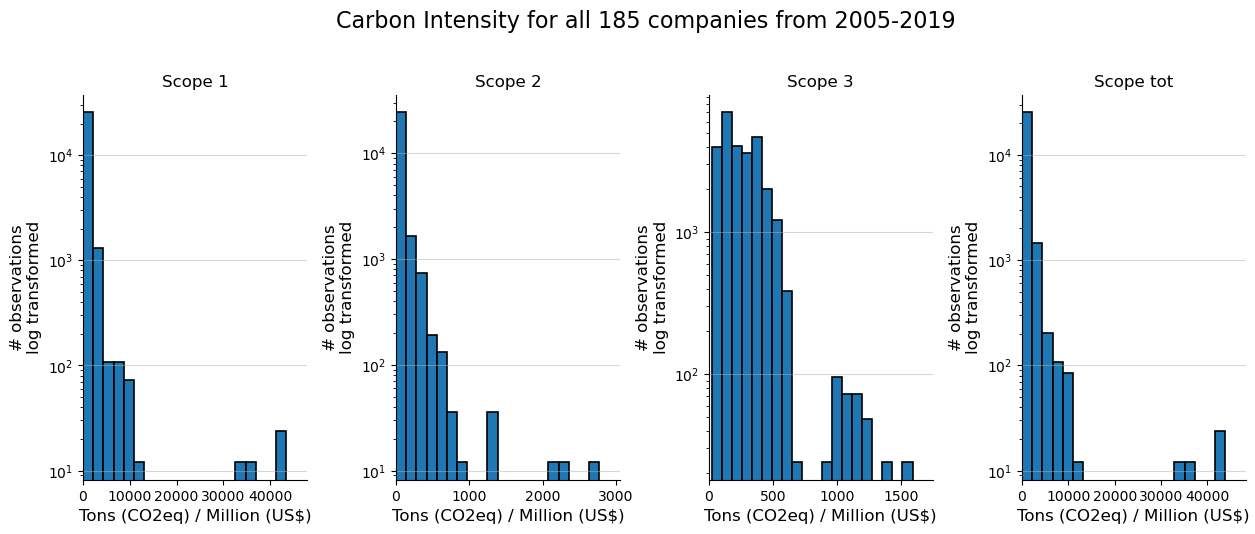

In [25]:

def get_hist_plot(data: pd.DataFrame, columns: list[str], title='Histogram', color=None, log=False):
    '''
    Function that creates a histogram plot on the given data for the given columns.
    xticks_rotation: rotation of xticks in degrees
    '''
    fig, axs = plt.subplots(nrows=1, ncols=len(columns), figsize=(15, 5))

    # Plot each set of data in a different subplot
    for i, col in enumerate(columns):
        # Calculate x-limits based on data in the column
        x_min = data[col].min()
        x_max = data[col].max()
        x_range = x_max - x_min
        x_min = max(0, x_min - 0.1 * x_range)
        x_max += 0.1 * x_range
        axs[i].hist(data[col], log=log, bins=20, edgecolor='black', linewidth=1.2, color=color)
        axs[i].set_xlim([x_min, x_max])
        axs[i].set_title(col.replace('_', ' '), fontsize=12)
        axs[i].set_xlabel('Tons (CO2eq) / Million (US$)', fontsize=12)
        axs[i].set_ylabel('# observations\nlog transformed', fontsize=12)
        axs[i].tick_params(axis='both', which='major', labelsize=10)
        axs[i].grid(axis='y', alpha=0.5)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
    fig.suptitle(title, fontsize=16, y=1.05)
    # Increase spacing between subplots
    fig.subplots_adjust(wspace=0.4)
    return plt

get_hist_plot(data=df_nrg_intensity, columns=scopes, title='Carbon Intensity for all 185 companies from 2005-2019', log=True).show()


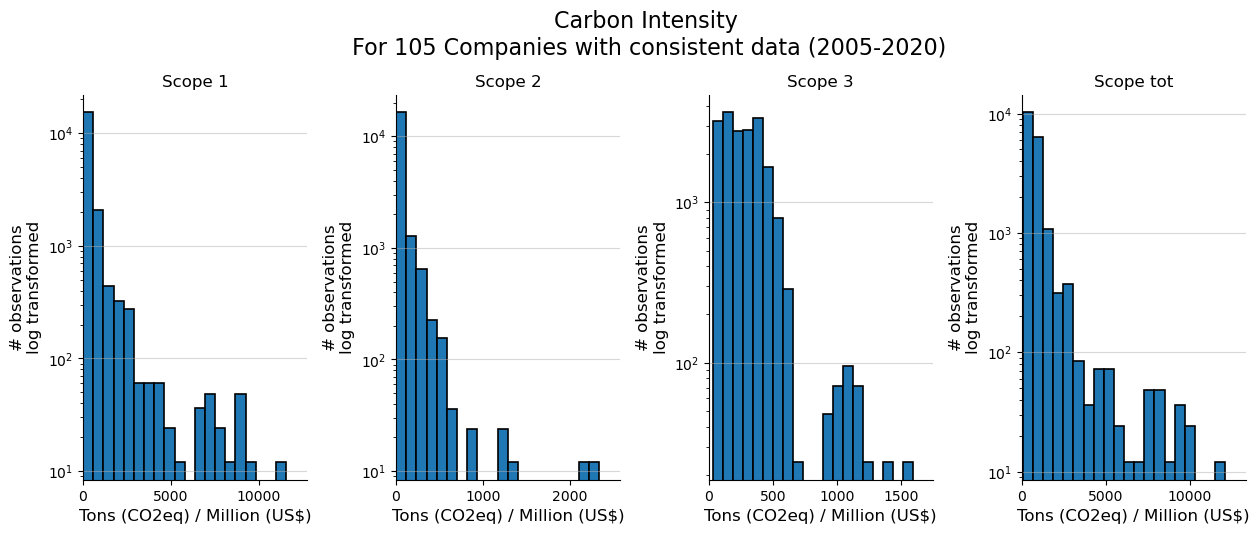

### Q2

In Question 4 of Homework 1, you calculated efficient portfolios with various target returns. Take these portfolios, calculate and report the weighted-average E/S/G score or weighted-average carbon intensity of these portfolios (you can take the average score/carbon intensity for each firm over time). Comment on the E/S/G score or carbon intensity of the portfolios. Which firms (e.g. top 10; report firm names along with ISIN) are driving the E/S/G score down or driving the carbon intensity up? Plot on the volatility-E/S/G score (carbon intensity) space the various portfolios (i.e., make a plot similar to the efficient frontier except that E/S/G score or carbon intensity replaces the return on the y-axis). (15 points)



### Q3

This question is a follow-up of Question 7 of Homework 1. First, take the same 100 selected firms. Then, create a minimum variance portfolio with monthly rebalancing with an additional constraint: you exclude the worst firms in terms of E/S/G score/most polluting (high carbon intensity) firms. Specifically, exclude the bottom tercile of the distribution in month t − 1 for ESG scores or exclude the top tercile of the distribution in month t − 1 for the carbon intensity. Report summary statistics on the performance (return, risk, Sharpe ratio) of this portfolio as well as its E/S/G score or carbon intensity. How do the performance measures (return, risk, Sharpe ratio) compare with the minimum variance portfolio from Question 3 of Homework 1. (20 points)

### Q4 

For each month, sort firms based on your group’s variable of interest (E/S/G scores or carbon intensity) into quintiles. Create equally-weighted and value-weighted portfolios for each time period and each score or carbon intensity quintile. Report the average returns for each quintile portfolio as well as a portfolio that goes long in the highest quintile and short the lowest quintile. Comment on your results. What can explain the relationship between the return of your portfolios and firms’ ESG score or carbon emissions? (25 points)

We need to keep in mind that we need values for the market cap to calculate the weight, so first we'll check if we have market cap data for all years.

In [27]:

# Checking how many observations we have using the count function
df_nrg_intensity_all_years.groupby('year')['market_cap'].count()

year
2005       0
2006       0
2007    1119
2008    1143
2009    1164
2010    1170
2011    1224
2012    1227
2013    1239
2014    1248
2015    1248
2016    1248
2017    1248
2018    1248
2019    1257
Name: market_cap, dtype: int64

Function do divide a portfolio into quintiles based on monthly carbon intensity. And for comparison we'll remove 2005-2007 from the dataset, as we only have the market cap from 2008 and onwards.

In [28]:
def create_portfolio_quintile(df: pd.DataFrame, quintiles: float):
    df = df.copy()

    # Grouping the df into year and month
    grouped = df.groupby(['date'])

    # Apply the qcut function to each group, dividing the Scope_tot column into quintiles, sorted for each month
    df['quintile'] = grouped['Scope_tot'].transform(
        lambda x: pd.qcut(x, q=quintiles, labels=False))
    df = df.sort_values(by=['date', 'Scope_tot'])
    return df


quintiles = 5
df_quintiles = create_portfolio_quintile(df_nrg_intensity_all_years, quintiles)

df_quintiles = df_quintiles[~df_quintiles['year'].isin([2005, 2006])]

display(df_quintiles)


,date,year,month,ISIN,monthly_return,market_cap,annual_returns,Scope_1,Scope_2,Scope_3,Scope_tot,quintile
1176,2007-01-31,2007,1,AU000000WOR2,0.111870,3.423190e+09,1.179681,8.624764,8.174710,58.648855,75.448329,0
11160,2007-01-31,2007,1,FR0013181864,0.081058,5.322350e+09,0.468598,6.225430,13.651768,72.684133,92.561331,0
19416,2007-01-31,2007,1,MYL5681OO001,0.092974,1.490180e+09,0.745022,26.337478,16.454474,59.908617,102.700569,0
21720,2007-01-31,2007,1,PK0022501016,-0.026337,9.620380e+08,0.427545,26.337478,16.454474,59.908617,102.700569,0
22296,2007-01-31,2007,1,PLLOTOS00025,0.043711,8.369560e+08,0.185103,27.668290,16.541421,62.131954,106.341665,0
...,...,...,...,...,...,...,...,...,...,...,...,...
755,2019-12-31,2019,12,AU000000ORG5,0.083612,1.044880e+10,0.203939,1706.964165,217.340694,406.709880,2331.014739,4
23603,2019-12-31,2019,12,RU0007661625,-0.049522,9.792200e+10,0.649419,2003.022990,71.056596,298.344670,2372.424257,4
8051,2019-12-31,2019,12,CNE000000SK7,-0.193773,3.652390e+09,-0.460636,2568.987069,154.242324,240.558638,2963.788031,4
35507,2019-12-31,2019,12,ZAE000006896,-0.027191,1.368820e+10,-0.491585,4105.292609,533.284849,287.350754,4925.928212,4


In [29]:
df_quintiles.ISIN.unique().shape[0]

105

Function to create an equally weighted portfolio for each quintile and function to create the portfolio statistics.

In [30]:
# Assuming a risk free rate of 3.5%
risk_free_rate = 0.035
months_in_year = 12


def create_equally_weighted_portfolio(df: pd.DataFrame):
    num_years = df.year.max() - df.year.min()
    assets_in_quintile = len(df['ISIN'].unique())/quintiles
    # Copying previous df
    df = df.copy()

    # Compute AAR for each ISIN
    df['AAR'] = df.groupby(['ISIN'])[
        'monthly_return'].transform('sum')/num_years

    # Compute equally-weighted portfolio statistics for each quintile in each month
    df['ew_annualized_volatility'] = df.groupby(['quintile'])[
        'monthly_return'].transform('std') * math.sqrt(months_in_year)
    df['ew_monthly_return'] = df.groupby(['date', 'quintile'])[
        'monthly_return'].transform('mean')
    df['ew_annual_return'] = df.groupby(['quintile', 'year'])[
        'ew_monthly_return'].transform('sum')/assets_in_quintile

    ew_df = df.groupby(['quintile','date'])['ew_monthly_return'].mean().groupby('quintile').sum()/num_years

    # Helper function to calcualte the AAR of each quintile
    def apply_ew(row):
        qintile = row['quintile']
        return ew_df[qintile]
    
    df['ew_AAR'] = df.apply(apply_ew, axis=1)

    return df


def create_portfolio_statistics(df: pd.DataFrame, portfoliotype=['ew', 'vw'], decimals=3):
    # Compute portfolio statistics for each quintile (hence q_) in each month
    q_min = df.groupby(['quintile'])[f'{portfoliotype}_monthly_return'].min()
    q_max = df.groupby(['quintile'])[f'{portfoliotype}_monthly_return'].max()
    q_AAR = df.groupby(['quintile'])[f'{portfoliotype}_AAR'].mean()

    q_volatility = df.groupby(['quintile'])[
        f'{portfoliotype}_annualized_volatility'].mean()

    q_sharperatio = (q_AAR - risk_free_rate) / q_volatility

    pretty_tuple = {
        'ew': 'Eq. W.',
        'vw': 'V. W.'
    }

    df_ret = pd.DataFrame()
    df_ret['Portfolio Intensity'] = df.groupby(['quintile'])['Scope_tot'].mean()
    df_ret['Portfolio Market Cap'] = df.groupby(['quintile'])['market_cap'].mean()
    df_ret[f'{pretty_tuple[portfoliotype]} AAR'] = q_AAR
    df_ret[f'{pretty_tuple[portfoliotype]} Annualized Mean Volatility'] = q_volatility
    df_ret[f'{pretty_tuple[portfoliotype]} Minimum Return'] = q_min
    df_ret[f'{pretty_tuple[portfoliotype]} Maximum Return'] = q_max
    df_ret[f'{pretty_tuple[portfoliotype]} Sharpe Ratio'] = q_sharperatio

    return df_ret.round(decimals)


df_quintile_e_portfolio = create_equally_weighted_portfolio(df_quintiles)
equally_weighted_stats = create_portfolio_statistics(
    df_quintile_e_portfolio, 'ew')

display(df_quintile_e_portfolio)
display(equally_weighted_stats.T)


,date,year,month,ISIN,monthly_return,market_cap,annual_returns,Scope_1,Scope_2,Scope_3,Scope_tot,quintile,AAR,ew_annualized_volatility,ew_monthly_return,ew_annual_return,ew_AAR
1176,2007-01-31,2007,1,AU000000WOR2,0.111870,3.423190e+09,1.179681,8.624764,8.174710,58.648855,75.448329,0,0.131988,0.424751,0.018694,0.368732,0.087465
11160,2007-01-31,2007,1,FR0013181864,0.081058,5.322350e+09,0.468598,6.225430,13.651768,72.684133,92.561331,0,-0.158639,0.424751,0.018694,0.368732,0.087465
19416,2007-01-31,2007,1,MYL5681OO001,0.092974,1.490180e+09,0.745022,26.337478,16.454474,59.908617,102.700569,0,0.196150,0.424751,0.018694,0.368732,0.087465
21720,2007-01-31,2007,1,PK0022501016,-0.026337,9.620380e+08,0.427545,26.337478,16.454474,59.908617,102.700569,0,0.089798,0.424751,0.018694,0.368732,0.087465
22296,2007-01-31,2007,1,PLLOTOS00025,0.043711,8.369560e+08,0.185103,27.668290,16.541421,62.131954,106.341665,0,0.177090,0.424751,0.018694,0.368732,0.087465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,2019-12-31,2019,12,AU000000ORG5,0.083612,1.044880e+10,0.203939,1706.964165,217.340694,406.709880,2331.014739,4,0.110785,0.410678,-0.051383,-0.235562,0.056936
23603,2019-12-31,2019,12,RU0007661625,-0.049522,9.792200e+10,0.649419,2003.022990,71.056596,298.344670,2372.424257,4,0.033171,0.410678,-0.051383,-0.235562,0.056936
8051,2019-12-31,2019,12,CNE000000SK7,-0.193773,3.652390e+09,-0.460636,2568.987069,154.242324,240.558638,2963.788031,4,0.293846,0.410678,-0.051383,-0.235562,0.056936
35507,2019-12-31,2019,12,ZAE000006896,-0.027191,1.368820e+10,-0.491585,4105.292609,533.284849,287.350754,4925.928212,4,0.029214,0.410678,-0.051383,-0.235562,0.056936


quintile,0,1,2,3,4
Portfolio Intensity,2.254570e+02,4.716130e+02,6.241770e+02,8.036010e+02,2.042880e+03
Portfolio Market Cap,1.842693e+10,2.106547e+10,3.880460e+10,5.099300e+10,2.461458e+10
Eq. W. AAR,8.700000e-02,8.900000e-02,7.800000e-02,7.500000e-02,5.700000e-02
Eq. W. Annualized Mean Volatility,4.250000e-01,4.380000e-01,3.880000e-01,3.560000e-01,4.110000e-01
Eq. W. Minimum Return,-3.180000e-01,-2.380000e-01,-2.140000e-01,-2.320000e-01,-3.020000e-01
Eq. W. Maximum Return,2.600000e-01,3.320000e-01,2.730000e-01,2.280000e-01,2.500000e-01
Eq. W. Sharpe Ratio,1.240000e-01,1.240000e-01,1.120000e-01,1.110000e-01,5.300000e-02


Now we can create the value weighted portfolio:

In [31]:
def create_value_weighted_portfolio(df: pd.DataFrame):
    df = df.copy()
    # Number of years under observation
    num_years = df.year.max() - df.year.min()

    # Get monthly total market value for each quintile
    df['monthly_market_cap_per_quintile'] = df.groupby(
        ['date', 'quintile'])['market_cap'].transform('sum')

    # Computing the value weight
    df['value_weight'] = df['market_cap']/df['monthly_market_cap_per_quintile']

    # Computing the monthly returns for each ISIN based on the market cap weight per month
    df['vw_monthly_asset_return'] = df['monthly_return'] * df['value_weight']

    # Computing the AAR of the value-weighted portfolio by summing all the monthly weighted returns across the portfolio and divided by years under observation
    df['vw_AAR'] = df.groupby(['quintile'])[
        'vw_monthly_asset_return'].transform('sum')/num_years

    # Computing the value-weighted portfolio monthly return
    df['vw_monthly_return'] = df.groupby(['date', 'quintile'])[
        'vw_monthly_asset_return'].transform('sum')

    # Computing the value-weighted portfolio annual return
    df['vw_annual_return'] = df.groupby(['year', 'quintile'])[
        'vw_monthly_asset_return'].transform('sum')

    # Computing value-weighted portfolio volatility
    df['vw_annualized_volatility'] = df.groupby(['quintile'])[
        'vw_monthly_return'].transform('std') * math.sqrt(months_in_year)

    return df

value_and_equally_weighted_portfolio_df = create_value_weighted_portfolio(df_quintile_e_portfolio)
value_and_equally_weighted_portfolio_df



,date,year,month,ISIN,monthly_return,market_cap,annual_returns,Scope_1,Scope_2,Scope_3,...,ew_monthly_return,ew_annual_return,ew_AAR,monthly_market_cap_per_quintile,value_weight,vw_monthly_asset_return,vw_AAR,vw_monthly_return,vw_annual_return,vw_annualized_volatility
1176,2007-01-31,2007,1,AU000000WOR2,0.111870,3.423190e+09,1.179681,8.624764,8.174710,58.648855,...,0.018694,0.368732,0.087465,2.592954e+11,0.013202,0.001477,0.093431,0.033854,0.591751,0.265823
11160,2007-01-31,2007,1,FR0013181864,0.081058,5.322350e+09,0.468598,6.225430,13.651768,72.684133,...,0.018694,0.368732,0.087465,2.592954e+11,0.020526,0.001664,0.093431,0.033854,0.591751,0.265823
19416,2007-01-31,2007,1,MYL5681OO001,0.092974,1.490180e+09,0.745022,26.337478,16.454474,59.908617,...,0.018694,0.368732,0.087465,2.592954e+11,0.005747,0.000534,0.093431,0.033854,0.591751,0.265823
21720,2007-01-31,2007,1,PK0022501016,-0.026337,9.620380e+08,0.427545,26.337478,16.454474,59.908617,...,0.018694,0.368732,0.087465,2.592954e+11,0.003710,-0.000098,0.093431,0.033854,0.591751,0.265823
22296,2007-01-31,2007,1,PLLOTOS00025,0.043711,8.369560e+08,0.185103,27.668290,16.541421,62.131954,...,0.018694,0.368732,0.087465,2.592954e+11,0.003228,0.000141,0.093431,0.033854,0.591751,0.265823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,2019-12-31,2019,12,AU000000ORG5,0.083612,1.044880e+10,0.203939,1706.964165,217.340694,406.709880,...,-0.051383,-0.235562,0.056936,4.370041e+11,0.023910,0.001999,0.075877,-0.018626,0.066813,0.270760
23603,2019-12-31,2019,12,RU0007661625,-0.049522,9.792200e+10,0.649419,2003.022990,71.056596,298.344670,...,-0.051383,-0.235562,0.056936,4.370041e+11,0.224076,-0.011097,0.075877,-0.018626,0.066813,0.270760
8051,2019-12-31,2019,12,CNE000000SK7,-0.193773,3.652390e+09,-0.460636,2568.987069,154.242324,240.558638,...,-0.051383,-0.235562,0.056936,4.370041e+11,0.008358,-0.001620,0.075877,-0.018626,0.066813,0.270760
35507,2019-12-31,2019,12,ZAE000006896,-0.027191,1.368820e+10,-0.491585,4105.292609,533.284849,287.350754,...,-0.051383,-0.235562,0.056936,4.370041e+11,0.031323,-0.000852,0.075877,-0.018626,0.066813,0.270760


In [32]:
value_weighted_stats = create_portfolio_statistics(value_and_equally_weighted_portfolio_df, 'vw', decimals=10)
value_weighted_stats.T

quintile,0,1,2,3,4
Portfolio Intensity,2.254572e+02,4.716131e+02,6.241772e+02,8.036008e+02,2.042880e+03
Portfolio Market Cap,1.842693e+10,2.106547e+10,3.880460e+10,5.099300e+10,2.461458e+10
V. W. AAR,9.343087e-02,1.228559e-01,1.070075e-01,7.239057e-02,7.587731e-02
V. W. Annualized Mean Volatility,2.658228e-01,2.583351e-01,2.185664e-01,2.070485e-01,2.707599e-01
V. W. Minimum Return,-2.500044e-01,-1.907544e-01,-1.588505e-01,-1.514655e-01,-2.868050e-01
V. W. Maximum Return,2.489856e-01,2.354080e-01,2.194479e-01,2.141060e-01,3.084537e-01
V. W. Sharpe Ratio,2.198113e-01,3.400851e-01,3.294536e-01,1.805884e-01,1.509725e-01


In [33]:
test = value_weighted_stats.T

test['0-4'] = test[0] - test[4]
test.round(5)


quintile,0,1,2,3,4,0-4
Portfolio Intensity,2.254572e+02,4.716131e+02,6.241772e+02,8.036008e+02,2.042880e+03,-1.817422e+03
Portfolio Market Cap,1.842693e+10,2.106547e+10,3.880460e+10,5.099300e+10,2.461458e+10,-6.187646e+09
V. W. AAR,9.343000e-02,1.228600e-01,1.070100e-01,7.239000e-02,7.588000e-02,1.755000e-02
V. W. Annualized Mean Volatility,2.658200e-01,2.583400e-01,2.185700e-01,2.070500e-01,2.707600e-01,-4.940000e-03
V. W. Minimum Return,-2.500000e-01,-1.907500e-01,-1.588500e-01,-1.514700e-01,-2.868100e-01,3.680000e-02
V. W. Maximum Return,2.489900e-01,2.354100e-01,2.194500e-01,2.141100e-01,3.084500e-01,-5.947000e-02
V. W. Sharpe Ratio,2.198100e-01,3.400900e-01,3.294500e-01,1.805900e-01,1.509700e-01,6.884000e-02


In [34]:
value_and_equally_weighted_portfolio_df[['Scope_tot', 'monthly_return', 'vw_annual_return','ew_annual_return']].corr()

,Scope_tot,monthly_return,vw_annual_return,ew_annual_return
Scope_tot,1.000000,0.012191,0.024787,0.024482
monthly_return,0.012191,1.000000,0.210515,0.224344
vw_annual_return,0.024787,0.210515,1.000000,0.938481
ew_annual_return,0.024482,0.224344,0.938481,1.000000


Now let's calculate the two portfolios that goes long in the best quintile and short in the poorest performing quintile (equally weighted and value weighted).

In [35]:

x = value_and_equally_weighted_portfolio_df[[
    'date', 'year', 'quintile', 'ew_monthly_return', 'vw_monthly_return']].copy()


num_years = x.year.max() - x.year.min()

x_q0 = x[(x['quintile'] == 0)].set_index('date')
x_q0.rename(columns={'ew_monthly_return': 'ew_monthly_return_long',
            'vw_monthly_return': 'vw_monthly_return_long'}, inplace=True)
x_q0.drop(columns=['year'], inplace=True)


x_q4 = x[(x['quintile'] == 4)].set_index('date')
x_q4.rename(columns={'ew_monthly_return': 'ew_monthly_return_short',
            'vw_monthly_return': 'vw_monthly_return_short'}, inplace=True)


long_short_df = pd.concat([x_q0, x_q4], axis=1)
long_short_df.drop(columns=['quintile'], inplace=True)


# Computing the long - short return for both the ew and vw portfolio
long_short_df['ew_long-short_return'] = long_short_df['ew_monthly_return_long'] - long_short_df['ew_monthly_return_short']
long_short_df['vw_long-short_return'] = long_short_df['vw_monthly_return_long'] - long_short_df['vw_monthly_return_short']

# Computing the value-weighted long-short portfolio annual return
long_short_df['vw_long-short_annual_return'] = long_short_df.groupby(['year'])[
    'vw_long-short_return'].transform('sum')/months_in_year

# Computing value-weighted portfolio statistics for each quintile in each month
long_short_df['vw_long-short_annualized_volatility'] = long_short_df['vw_long-short_return'].std() * math.sqrt(months_in_year)

# Computing the equal weighted long-short annual return
long_short_df['ew_long-short_annual_return'] = long_short_df.groupby(['year'])['ew_long-short_return'].transform('mean')
# Compute equally-weighted portfolio statistics for each quintile in each month
long_short_df['ew_long-short_annualized_volatility'] = long_short_df['ew_long-short_return'].std() * math.sqrt(months_in_year)

np.std

# Displaying statistics for the long-short portfolios
def create_long_short_statistics(df: pd.DataFrame, portfoliotype=['ew', 'vw'], decimals=5, risk_free_rate=0.035):
    min = df[f'{portfoliotype}_long-short_return'].min()
    max = df[f'{portfoliotype}_long-short_return'].max()
    AAR = df[f'{portfoliotype}_long-short_annual_return'].mean()
    
    volatility = df[f'{portfoliotype}_long-short_annualized_volatility'].mean()

    sharperatio = (AAR - risk_free_rate) / volatility

    pretty_tuple = {
        'ew': 'Eq. W. Long-Short',
        'vw': 'V. W. Long-Short'
    }

    df_ret = pd.DataFrame()
    df_ret[f'{pretty_tuple[portfoliotype]} AAR'] = [AAR]
    df_ret[f'{pretty_tuple[portfoliotype]} Annualized Mean Volatility'] = [volatility]
    df_ret[f'{pretty_tuple[portfoliotype]} Minimum Return'] = [min]
    df_ret[f'{pretty_tuple[portfoliotype]} Maximum Return'] = [max]
    df_ret[f'{pretty_tuple[portfoliotype]} Sharpe Ratio'] = [sharperatio]

    return df_ret.round(decimals)
 
ew_long_short_stats = create_long_short_statistics(long_short_df, 'ew').T
vw_long_short_stats = create_long_short_statistics(long_short_df, 'vw').T

display(ew_long_short_stats)
display(vw_long_short_stats)



,0
Eq. W. Long-Short AAR,0.00235
Eq. W. Long-Short Annualized Mean Volatility,0.11395
Eq. W. Long-Short Minimum Return,-0.09442
Eq. W. Long-Short Maximum Return,0.10242
Eq. W. Long-Short Sharpe Ratio,-0.28654


,0
V. W. Long-Short AAR,0.02836
V. W. Long-Short Annualized Mean Volatility,0.14074
V. W. Long-Short Minimum Return,-0.15069
V. W. Long-Short Maximum Return,0.10561
V. W. Long-Short Sharpe Ratio,-0.04721


In [36]:
display(long_short_df[['year','ew_long-short_return']].groupby('year').mean().mean())
display(long_short_df['ew_long-short_annual_return'].unique().mean())
display(long_short_df[['year','ew_long-short_return']])

ew_long-short_return    0.002348
dtype: float64

0.002348351517909119

,year,ew_long-short_return
date,,
2007-01-31,2007,-0.011214
2007-01-31,2007,-0.011214
2007-01-31,2007,-0.011214
2007-01-31,2007,-0.011214
2007-01-31,2007,-0.011214
...,...,...
2019-12-31,2019,0.025425
2019-12-31,2019,0.025425
2019-12-31,2019,0.025425


For both the v-w and the e-w portfolios, we will now create a portfolio that goes long in the lowest intensity score and short in the highest intensity score (1: best, 5: worst)

Lets plot some of our results!

In [48]:
q4 = value_and_equally_weighted_portfolio_df.copy()

x = q4.groupby('year').year.mean()

# Create figure
fig = go.Figure()

line_width = 2

for q in range(5):
    y = q4[q4.quintile == q].groupby(['year']).vw_annual_return.mean()
    fig.add_trace(go.Scatter(x=x, y=y, name=f'V. W. Quintile {q+1}',
              line=dict(color='darkblue', width=line_width)))

    y = q4[q4.quintile == q].groupby(['year']).ew_annual_return.mean()
    fig.add_trace(go.Scatter(x=x, y=y, name=f'Eq. W. Quintile {q+1}',
              line=dict(color='skyblue', width=line_width)))

# Update layout
fig.update_layout(title='Portfolio Performance by Year',
                  xaxis_title='Year',
                  yaxis_title='Annual Return',
                  legend_title='Portfolio Type',
                  font=dict(size=10),
                  plot_bgcolor='white')

# Center legend title
fig.update_layout(legend=dict(title=dict(text='Portfolio Type', font=dict(size=18), side='top')),
                  legend_title_font=dict(size=18),
                  legend_title_side='top')

# Center plot title
fig.update_layout(title=dict(text='Equal and Value Weighted Quintile Portfolio Performance by Year',
                  font=dict(size=22), x=0.4, xanchor='center'))


# Customize axes
fig.update_xaxes(tickvals=x,
                 ticktext=[str(int(val)) for val in x],
                 tickangle=45,
                 dtick=1,
                 tickfont=dict(size=14),
                 gridcolor='lightgray',
                 zeroline=False)

fig.update_yaxes(tickfont=dict(size=14),
                 gridcolor='lightgray',
                 zeroline=False)

fig.show()


In [38]:
value_and_equally_weighted_portfolio_df[['vw_annual_return', 'year']].groupby(['year'])

In [49]:
q4 = value_and_equally_weighted_portfolio_df.copy()

x = q4['year']

y_2_vw_long_short = long_short_df['vw_long-short_annual_return']
y_2_ew_long_short = long_short_df['ew_long-short_annual_return']

# Create figure
fig = go.Figure()

line_width = 5

# Add time series traces
fig.add_trace(go.Scatter(x=long_short_df.year, y=y_2_ew_long_short, name='Eq. W. Long-Short ',
             line=dict(color='blue', width=line_width)))
fig.add_trace(go.Scatter(x=long_short_df.year, y=y_2_vw_long_short, name='V. W. Long-Short ',
             line=dict(color='turquoise', width=line_width)))


# Update layout
fig.update_layout(title='Portfolio Performance by Year',
                  xaxis_title='Year',
                  yaxis_title='Annual Return',
                  legend_title='Portfolio Type',
                  font=dict(size=12),
                  plot_bgcolor='white')

# Center legend title
fig.update_layout(legend=dict(title=dict(text='Portfolio Type', font=dict(size=16), side='top')),
                  legend_title_font=dict(size=16),
                  legend_title_side='top')

# Center plot title
fig.update_layout(title=dict(text='Long-Short Portfolio Performance by Year',
                  font=dict(size=18), x=0.4, xanchor='center'))


# Customize axes
fig.update_xaxes(tickvals=x,
                 ticktext=[str(int(val)) for val in x],
                 tickangle=45,
                 dtick=1,
                 tickfont=dict(size=14),
                 gridcolor='lightgray',
                 zeroline=False)

fig.update_yaxes(tickfont=dict(size=14),
                 gridcolor='lightgray',
                 zeroline=False)

fig.show()


In [43]:
q4 = value_and_equally_weighted_portfolio_df.copy()

x = q4['year']

y1_vw_mean = q4.groupby(['year'])['vw_annual_return'].transform('mean')
y1_ew_mean = q4.groupby(['year'])['ew_annual_return'].transform('mean')


y_2_vw_long_short = long_short_df['vw_long-short_annual_return']
y_2_ew_long_short = long_short_df['ew_long-short_annual_return']

# Create figure
fig = go.Figure()

line_width = 5

# Add time series traces
fig.add_trace(go.Scatter(x=x, y=y1_vw_mean, name='V. W. Quintile 1-5',
              line=dict(color='darkblue', width=line_width)))
fig.add_trace(go.Scatter(x=x, y=y1_ew_mean, name='Eq. W. Quintile 1-5',
              line=dict(color='skyblue', width=line_width)))
# fig.add_trace(go.Scatter(x=long_short_df.year, y=y_2_ew_long_short, name='V. W. Long-Short ',
#              line=dict(color='blue', width=line_width)))
# fig.add_trace(go.Scatter(x=long_short_df.year, y=y_2_vw_long_short, name='Eq. W. Long-Short ',
#              line=dict(color='turquoise', width=line_width)))


# Update layout
fig.update_layout(title='Portfolio Performance by Year',
                  xaxis_title='Year',
                  yaxis_title='Annual Return',
                  legend_title='Portfolio Type',
                  font=dict(size=12),
                  plot_bgcolor='white')

# Center legend title
fig.update_layout(legend=dict(title=dict(text='Portfolio Type', font=dict(size=16), side='top')),
                  legend_title_font=dict(size=16),
                  legend_title_side='top')

# Center plot title
fig.update_layout(title=dict(text='Portfolio Performance by Year',
                  font=dict(size=18), x=0.4, xanchor='center'))


# Customize axes
fig.update_xaxes(tickvals=x,
                 ticktext=[str(int(val)) for val in x],
                 tickangle=45,
                 dtick=1,
                 tickfont=dict(size=14),
                 gridcolor='lightgray',
                 zeroline=False)

fig.update_yaxes(tickfont=dict(size=14),
                 gridcolor='lightgray',
                 zeroline=False)

fig.show()


Exporting the Q4 statistics to EXCEL

In [40]:
display(ew_long_short_stats)
display(vw_long_short_stats)
display(equally_weighted_stats.T)
display(value_weighted_stats.T)

# Specify the file name for export
file = './output/q_4_stats.xlsx'

# Create ExcelWriter object
writer = pd.ExcelWriter(file)

# Write DataFrame 1 to Sheet 1
ew_long_short_stats.to_excel(writer, sheet_name='Sheet1', index=False)

# Write DataFrame 2 to Sheet 2
vw_long_short_stats.to_excel(writer, sheet_name='Sheet2', index=False)

# Write DataFrame 1 to Sheet 1
equally_weighted_stats.T.to_excel(writer, sheet_name='Sheet3', index=False)

# Write DataFrame 2 to Sheet 2
value_weighted_stats.T.to_excel(writer, sheet_name='Sheet4', index=False)

# Save and close the ExcelWriter object
writer.save()


,0
Eq. W. Long-Short AAR,0.00235
Eq. W. Long-Short Annualized Mean Volatility,0.11395
Eq. W. Long-Short Minimum Return,-0.09442
Eq. W. Long-Short Maximum Return,0.10242
Eq. W. Long-Short Sharpe Ratio,-0.28654


,0
V. W. Long-Short AAR,0.02836
V. W. Long-Short Annualized Mean Volatility,0.14074
V. W. Long-Short Minimum Return,-0.15069
V. W. Long-Short Maximum Return,0.10561
V. W. Long-Short Sharpe Ratio,-0.04721


quintile,0,1,2,3,4
Portfolio Intensity,2.254570e+02,4.716130e+02,6.241770e+02,8.036010e+02,2.042880e+03
Portfolio Market Cap,1.842693e+10,2.106547e+10,3.880460e+10,5.099300e+10,2.461458e+10
Eq. W. AAR,8.700000e-02,8.900000e-02,7.800000e-02,7.500000e-02,5.700000e-02
Eq. W. Annualized Mean Volatility,4.250000e-01,4.380000e-01,3.880000e-01,3.560000e-01,4.110000e-01
Eq. W. Minimum Return,-3.180000e-01,-2.380000e-01,-2.140000e-01,-2.320000e-01,-3.020000e-01
Eq. W. Maximum Return,2.600000e-01,3.320000e-01,2.730000e-01,2.280000e-01,2.500000e-01
Eq. W. Sharpe Ratio,1.240000e-01,1.240000e-01,1.120000e-01,1.110000e-01,5.300000e-02


quintile,0,1,2,3,4
Portfolio Intensity,2.254572e+02,4.716131e+02,6.241772e+02,8.036008e+02,2.042880e+03
Portfolio Market Cap,1.842693e+10,2.106547e+10,3.880460e+10,5.099300e+10,2.461458e+10
V. W. AAR,9.343087e-02,1.228559e-01,1.070075e-01,7.239057e-02,7.587731e-02
V. W. Annualized Mean Volatility,2.658228e-01,2.583351e-01,2.185664e-01,2.070485e-01,2.707599e-01
V. W. Minimum Return,-2.500044e-01,-1.907544e-01,-1.588505e-01,-1.514655e-01,-2.868050e-01
V. W. Maximum Return,2.489856e-01,2.354080e-01,2.194479e-01,2.141060e-01,3.084537e-01
V. W. Sharpe Ratio,2.198113e-01,3.400851e-01,3.294536e-01,1.805884e-01,1.509725e-01


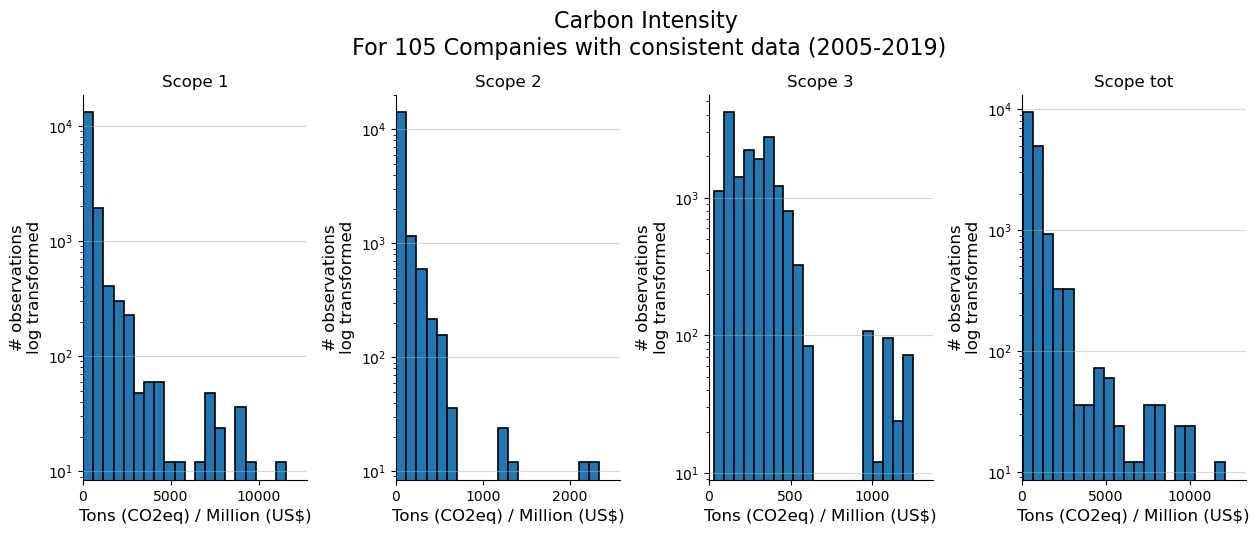

In [50]:
get_hist_plot(data=df_quintiles, columns=scopes, title='Carbon Intensity\n For 105 Companies with consistent data (2005-2019)', log=True).show()



### Q5

Take the minimum variance portfolio from Question 3 of Homework 1 and calculate its E/S/G score or carbon intensity. Reallocate its composition in order to improve the E/S/G score by 20%/reduce carbon intensity by 50% (see optimization problem below). Comment on the changes it took in order to improve the ESG score/carbon intensity (e.g., how many and which firms (firm names) had to be removed in the most recent year of your sample in order to achieve these objectives). (30 points)

$$\min_{\alpha} \quad \alpha' \sum{\alpha}$$
$$\text{s.a.} \quad \alpha' e = 1$$
$$\quad \quad \alpha'\text{CI} \leq 0.5 \times \left( \alpha' CI \right)_{Q3-Homework1}$$